In [1]:
# !pip install geopandas
# !pip install pandas==1.4.1
# !pip install osmnx
# !pip install rioxarray
# !pip install datashader
# !pip install contextily
# !pip install shapely
# !pip install matplotlib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import osmnx
import geopandas
import rioxarray
import xarray
import datashader
import contextily as cx
from shapely import geometry
import matplotlib.pyplot as plt


In [4]:
from IPython.display import Image

Geographic processes are represented using objects, fields, and networks.

* **Objects** are discrete entities that occupy a specific position in space and time.

* **Fields** are continuous surfaces that could, in theory, be measured at any location in space and time.

* **Networks** reflect a set of **connections** between objects or between positions in a field.

## Geographic data structures

### Geographic tables:
* store information about discrete objects. 
* like typical data tables each row represents an independent object, while each column stores an attribute of those objects (geographic and non-geographic information) 

![geographic table](supporting_files/geographic_table.png)

### Surface data:
* used to record empirical measurements for field data models
* surfaces are stored in uniform grids, or arrays whose dimension is closely linked to the geographic extent of the area they represent
* multi-dimensional arrays are sometimes called **data cubes** or **volumes**
![surface data](supporting_files/surface_data.png)

### Spatial networks:
* capture relationships between objects that are mediated through space 
* record information about how a given observation is spatially connected to others in the dataset
![spatial network](supporting_files/spatial_network.png)

#### Note: Storing network information is not as straightforward as when you have tables or surfaces.
Unlike tables or surfaces, relationships between observations do not have a clearly defined structure, shape and dimensionality in which data are organized:

Some points might have connections to many other points while others only have a few.

**Ways of storing networks:**
* as graphs with nodes and edges where nodes represent certain locations and edges represent paths between these locations
* as spatial weights matrices

## Hybrids
### Surfaces as tables
By shifting to tables we will lose that space-time reference that is stored in the surface data structure.

**Why do it?**
* Location is not needed for a particular application
* Tables represent the most common data structure available, therefore, there are many tools and techniques we can use to analyse the data

**Two ways of going from surfaces to tables:**
1. Convert every pixel into a table row
2. Aggregate pixels into predetermined polygons

###  Tables as surfaces
Conversion from a geo-table into a surface: 
* Lay out a grid and count how many points fall within each cell
* Done using `datashader` library, which does all the computation in a very efficient way
* Usually used to illustrate the overall distribution of data points

Again: This is a type of aggregation so we will lose some information on a data point level

### Networks as graphs and tables
**Why do it?**
* We wish to operate on each component of the network independently, e.g., we want to map streets, calculate segment lengths, or draw buffers around each intersection

**How to do it:**
<br>
Simply convert our graph to two geo-tables:
1. one for intersections (graph nodes) 
2. and one for street segments (graph edges)


In [5]:
gt_polygons = geopandas.read_file(
    "data/countries/countries_clean.gpkg"
)
gt_polygons.head()

,ADMIN,geometry
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102..."
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101..."
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828...."
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77..."


* one row per country
* `ADMIN`: coutnry name
* `geometry`: geometry of the country’s boundary

In [6]:
type(gt_polygons)

geopandas.geodataframe.GeoDataFrame

In [7]:
type(gt_polygons.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

We can create a map by calling `.plot()`. This will automatically use the `geometry` column to create a map:

<Axes: >

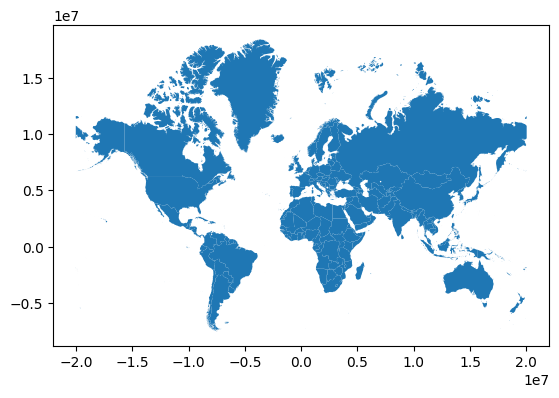

In [8]:
gt_polygons.plot()

In order to adjust the geometry and plot other elements we need to make sure that a new geometry column was set properly using the `set_geometry()` method each.

Let us add centroids of each country using its centroid:

In [76]:
gt_polygons["centroid"] = gt_polygons.geometry.centroid

In [77]:
gt_polygons.head()

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)
1,Malaysia,"MULTIPOLYGON (((13102705.696 463877.598, 13101...",POINT (12211696.493 422897.505)
2,Chile,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-7959811.948 -4915458.802)
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)
4,Peru,"MULTIPOLYGON (((-7737827.685 -1979875.500, -77...",POINT (-8277554.831 -1032942.536)


In [78]:
type(gt_polygons.centroid[0])

shapely.geometry.point.Point

The newlycreated column `centroid` is a geometry column. However, in order to have it displayed on our map, we need to use the `set_geometry()` as mentioned above:

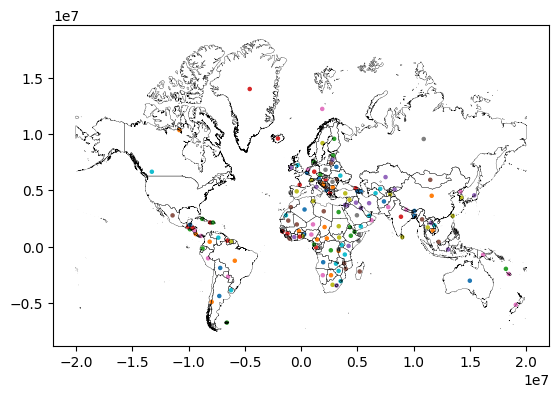

In [79]:
# Plot centroids
# Centroids are colored by country
ax = gt_polygons.set_geometry("centroid").plot("ADMIN", markersize=5)
# Plot polygons without color filling
gt_polygons.plot(
    "ADMIN", ax=ax, facecolor="none", edgecolor="k", linewidth=0.2
)

The Open Geospatial Consortium (OGC) has defined a set of “abstract” types that can be used to define any kind of geometry: 
* `Point`: zero-dimensional location with an x and y coordinate
* `LineString`: a path composed of a set of more than one Point
* `Polygon`: surface that has at least one LineString that starts and stops with the same coordinate

All of these types also have `Multi` variants that indicate a collection of multiple geometries of the same type. 

Bolivia is represented as a single `Polygon`:

In [80]:
gt_polygons.query('ADMIN == "Bolivia"')

,ADMIN,geometry,centroid
3,Bolivia,"POLYGON ((-7737827.685 -1979875.500, -7737828....",POINT (-7200010.945 -1894653.148)


<Axes: >

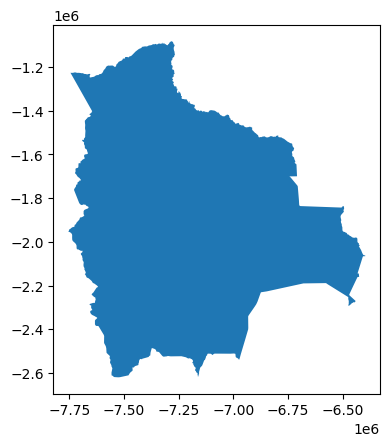

In [81]:
gt_polygons.query('ADMIN == "Bolivia"').plot()

Indonesia is a `MultiPolygon` containing many Polygons for each individual island in the country:

In [82]:
gt_polygons.query('ADMIN == "Indonesia"')

,ADMIN,geometry,centroid
0,Indonesia,"MULTIPOLYGON (((13102705.696 463877.598, 13102...",POINT (13055431.810 -248921.141)


<Axes: >

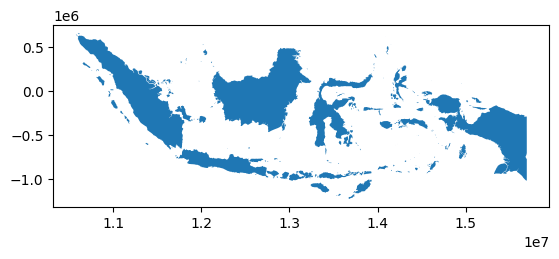

In [83]:
gt_polygons.query('ADMIN == "Indonesia"').plot()

**Point:** simplest type of feature, only a pair of coordinates
<br>
Therefore, points can sometimes be stored in a non-geographic table, simply using one column for each coordinate. 

In [84]:
gt_points = pd.read_csv("data/tokyo/tokyo_clean.csv")

In [85]:
type(gt_points)

pandas.core.frame.DataFrame

In [86]:
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


Convert table into `GeoDataFrame` table in two steps:
1. turn the raw coordinates into geometries

In [87]:
pt_geoms = geopandas.points_from_xy(
    x=gt_points["longitude"],
    y=gt_points["latitude"],
    # x,y are Earth longitude & latitude
    crs="EPSG:4326",
)

2. create a `GeoDataFrame` object using these geometries

In [88]:
gt_points = geopandas.GeoDataFrame(gt_points, geometry=pt_geoms)
gt_points.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y,geometry
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06,POINT (139.70050 35.67400)
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06,POINT (139.76652 35.70909)
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06,POINT (139.76563 35.69448)
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06,POINT (139.78439 35.54859)
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06,POINT (139.76875 35.67152)


<Axes: >

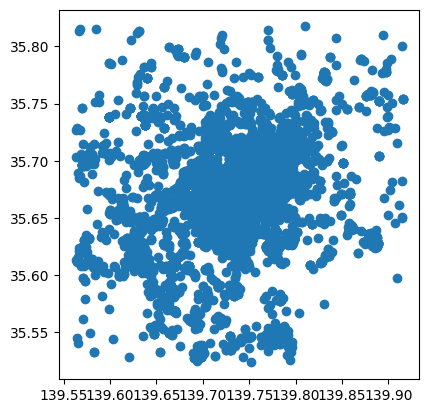

In [89]:
gt_points.plot()

In [90]:
pop = xarray.open_rasterio("data/ghsl/ghsl_sao_paulo.tif")

In [91]:
type(pop)

xarray.core.dataarray.DataArray

In [92]:
pop.coords

Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06

In [93]:
pop.attrs

{'transform': (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0),
 'crs': '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True',
 'res': (250.0, 250.0),
 'is_tiled': 0,
 'nodatavals': (-200.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Area',
 'grid_mapping': 'spatial_ref'}

In [94]:
pop.shape

(1, 416, 468)

In [95]:
pop.sel(band=1)

<xarray.DataArray (y: 416, x: 468)>
[194688 values with dtype=float32]
Coordinates:
    band     int64 1
  * y        (y) float64 -2.822e+06 -2.822e+06 ... -2.926e+06 -2.926e+06
  * x        (x) float64 -4.482e+06 -4.482e+06 ... -4.365e+06 -4.365e+06
Attributes:
    transform:      (250.0, 0.0, -4482000.0, 0.0, -250.0, -2822000.0)
    crs:            +proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +...
    res:            (250.0, 250.0)
    is_tiled:       0
    nodatavals:     (-200.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

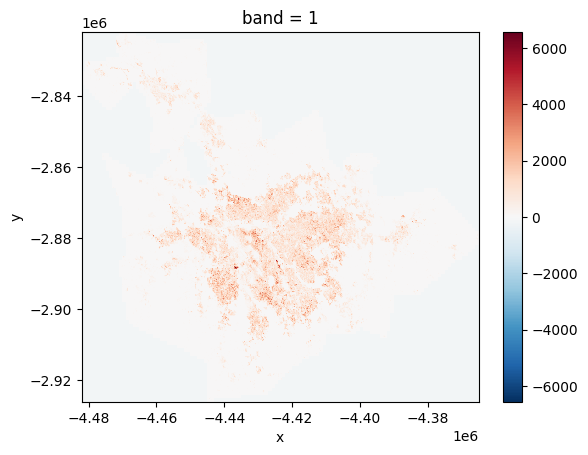

In [96]:
pop.sel(band=1).plot();

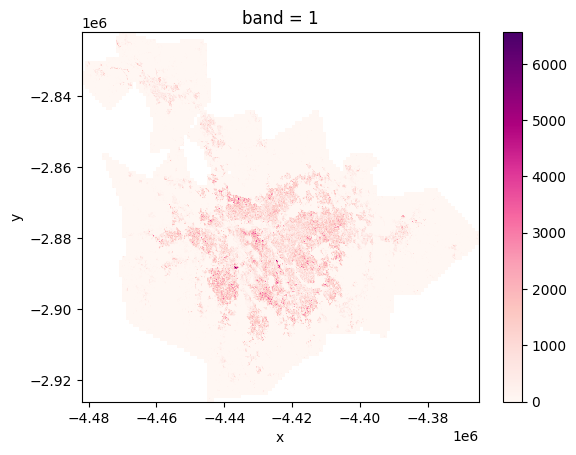

In [97]:
pop.where(pop != -200).sel(band=1).plot(cmap="RdPu");

In [98]:
graph = osmnx.graph_from_place("Yoyogi Park, Shibuya, Tokyo, Japan")

In [99]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

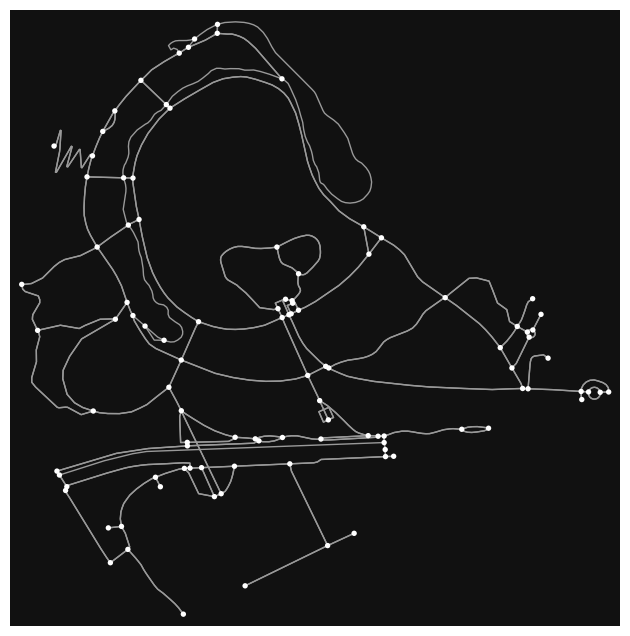

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [100]:
osmnx.plot_graph(graph)

In [101]:
len(graph.nodes)

103

In [103]:
graph.nodes[1520546819]

{'y': 35.6711267, 'x': 139.6925951, 'street_count': 4}

In [104]:
len(graph.edges)

278

In [105]:
graph.edges

OutMultiEdgeView([(886196069, 1520546857, 0), (886196069, 886196187, 0), (886196069, 1519651427, 0), (886196073, 886196100, 0), (886196073, 886196106, 0), (886196073, 1520829357, 0), (886196100, 886196073, 0), (886196100, 886203360, 0), (886196100, 1520829300, 0), (886196106, 1520546535, 0), (886196106, 886196073, 0), (886196106, 886196117, 0), (886196106, 1520829357, 0), (886196117, 886196195, 0), (886196117, 886196121, 0), (886196117, 886196106, 0), (886196121, 886196195, 0), (886196121, 886196117, 0), (886196121, 886196146, 0), (886196146, 1520547110, 0), (886196146, 886196121, 0), (886196146, 1520546948, 0), (886196187, 886229752, 0), (886196187, 6856536019, 0), (886196187, 1519651420, 0), (886196187, 886196069, 0), (886196195, 886196121, 0), (886196195, 886196117, 0), (886196195, 1520546563, 0), (886203360, 1520829246, 0), (886203360, 1520546535, 0), (886203360, 886196100, 0), (886229752, 886196187, 0), (886229752, 1520546559, 0), (886229752, 6856536019, 0), (886229752, 1519651425

In [106]:
graph.edges[(1520546819, 3010293622, 0)]

{'osmid': 138670840,
 'highway': 'footway',
 'oneway': False,
 'reversed': False,
 'length': 59.113,
 'geometry': <shapely.geometry.linestring.LineString at 0x7ff3019622e0>}

In [107]:
list(graph.adj[1520546819].keys())

[3010293622, 5764960322, 1913626649, 1520546959]

In [110]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

## Spatial weights
Constructs that represent geographic relationships between units in a spatially referenced dataset.

Common spatial questions: 
* What neighborhoods are you surrounded by? 
* How many gas stations are within 5 miles of my stalled car? 

We will cover weights derived from 
1. contiguity/adjacency based relationships and 
2. distance based relationships.

Package used: `pysal`

In [111]:
from pysal.lib import weights

In [112]:
# Get points in a grid
l = numpy.arange(3)
xs, ys = numpy.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)

### 1. Contiguity/Adjacency based weights
A **contiguous pair** of spatial objects are those who **share a common border**.

![weights example](supporting_files/spatial_weights_empty.png)

#### Rook contiguity
$$\text{A pair of polygons is a contiguous pair } {\bf{iff}}  \text{ they share an edge.}$$
![rook_contiguity](supporting_files/rook_contiguity.png)

In [113]:
# Build a rook contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wr = weights.contiguity.Rook.from_dataframe(gdf)

We can obtain the neighbors through the `neighbors` attribute which returns a dictionary that contains every polygon as a key and a list of their corresponding neighbors as values.

In [114]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

A full view of the neighborhood information can be retrieved as well:

In [115]:
pd.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


In [116]:
wr.nonzero

24

#### Queen contiguity
$$\text{A pair of polygons is a contiguous pair } {\bf{iff}}  \text{ they share one or more vertices.}$$
![queen_contiguity](supporting_files/queen_contiguity.png)

In [117]:
# Build a queen contiguity matrix from a regular 3x3
# lattice stored in a geo-table
wq = weights.contiguity.Queen.from_dataframe(gdf)
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

Each connection between observations have a weight attribute which can be obtained by the `weights` attribute.
<br>

**Note:** For contiguity weights, observations are usually either considered **linked** or **not linked**, so the resulting weights matrix is binary:

In [118]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

In [ ]:
# row standardising 

In [149]:
wq.transform = "R"
wq.weights

{0: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 1: [0.2, 0.2, 0.2, 0.2, 0.2],
 2: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 3: [0.2, 0.2, 0.2, 0.2, 0.2],
 4: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 5: [0.2, 0.2, 0.2, 0.2, 0.2],
 6: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 7: [0.2, 0.2, 0.2, 0.2, 0.2],
 8: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]}

#### Application on real-world geographic tables

In [119]:
san_diego_tracts = geopandas.read_file(
    "data/sandiego/sandiego_tracts.gpkg"
)
w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts)

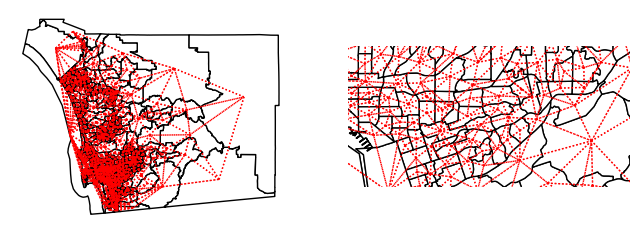

In [120]:
# Plot tract geography
f, axs = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax = san_diego_tracts.plot(
        edgecolor="k", facecolor="w", ax=axs[i]
    )
    # Plot graph connections
    w_queen.plot(
        san_diego_tracts,
        ax=axs[i],
        edge_kws=dict(color="r", linestyle=":", linewidth=1),
        node_kws=dict(marker=""),
    )
    # Remove the axis
    axs[i].set_axis_off()
axs[1].axis([-13040000, -13020000, 3850000, 3860000]);

In [121]:
w_queen.neighbors

{0: [1, 385, 4, 548, 27, 383],
 1: [0, 386, 4, 548, 84, 310],
 2: [99, 228, 551, 8, 554, 464, 241, 85, 472, 89],
 3: [312, 237, 150, 87],
 4: [0, 1, 7, 488, 27, 556, 239, 559, 310, 475, 479],
 5: [395, 555, 27, 318, 235],
 6: [8, 97, 394, 89],
 7: [227, 4, 310, 479, 251, 253, 95],
 8: [97, 2, 161, 6, 472, 89],
 9: [32, 555, 27, 11],
 10: [165, 166, 316, 317, 94],
 11: [32, 245, 9, 395, 397, 555],
 12: [562, 244, 165, 474, 315],
 13: [98, 102, 15],
 14: [101, 104, 238, 399, 400, 244, 473, 474],
 15: [98, 100, 102, 233, 13, 16, 469, 155],
 16: [480, 561, 100, 404, 102, 15],
 17: [256, 321, 163, 164, 234, 557, 21, 438, 471, 91, 573],
 18: [481, 322, 562, 564, 246, 567],
 19: [569, 485, 406, 247],
 20: [325, 486, 247, 568, 569, 106],
 21: [17, 162, 179, 573, 248, 557],
 22: [405, 566, 171, 172, 494],
 23: [322, 564, 567, 250, 252, 334],
 24: [32, 577, 257, 108, 407, 409, 26, 255],
 25: [576, 485, 328, 31, 175],
 26: [497, 578, 24, 409, 491, 492, 255],
 27: [0,
  385,
  4,
  5,
  390,
  391

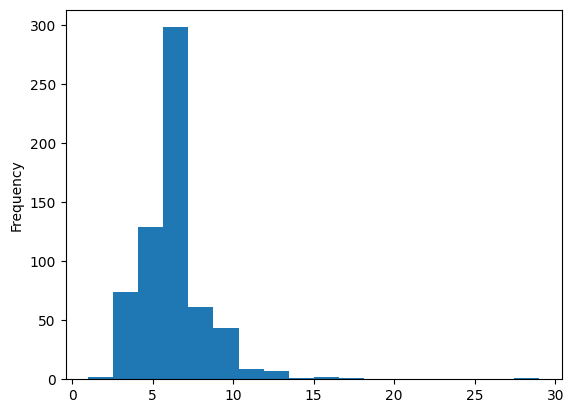

In [122]:
s = pd.Series(w_queen.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

### 2. Distance based weights


#### K-Nearest Neighbor weights
$$\text{Polygon $A$ is a neighbor of polygon $B$ } {\bf{iff}}  \text{ $A$ is contained in the set of the $k$ nearest neighbors of $B$. }$$

In [123]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

In [124]:
wk4.neighbors

{0: [548, 383, 384, 386],
 1: [386, 83, 384, 462],
 2: [464, 554, 228, 89],
 3: [312, 150, 237, 232],
 4: [488, 310, 227, 309],
 5: [235, 395, 96, 318],
 6: [8, 97, 394, 89],
 7: [95, 227, 237, 309],
 8: [6, 472, 97, 89],
 9: [11, 167, 555, 397],
 10: [316, 94, 317, 165],
 11: [555, 397, 395, 245],
 12: [315, 165, 474, 316],
 13: [102, 15, 16, 480],
 14: [101, 238, 104, 473],
 15: [13, 100, 16, 233],
 16: [404, 15, 13, 561],
 17: [163, 471, 21, 164],
 18: [246, 564, 567, 481],
 19: [406, 485, 569, 247],
 20: [486, 569, 325, 106],
 21: [162, 573, 319, 557],
 22: [172, 566, 405, 171],
 23: [252, 250, 567, 564],
 24: [255, 409, 577, 257],
 25: [175, 576, 328, 490],
 26: [409, 492, 255, 491],
 27: [91, 234, 471, 390],
 28: [583, 111, 184, 332],
 29: [181, 414, 180, 176],
 30: [584, 495, 112, 122],
 31: [580, 110, 576, 335],
 32: [171, 566, 405, 167],
 33: [263, 342, 113, 183],
 34: [119, 421, 263, 415],
 35: [187, 271, 334, 336],
 36: [186, 350, 581, 513],
 37: [590, 429, 506, 39],
 38: [4

In [147]:
wk4.transform = "R"

In [148]:
wk4.weights

{0: [0.25, 0.25, 0.25, 0.25],
 1: [0.25, 0.25, 0.25, 0.25],
 2: [0.25, 0.25, 0.25, 0.25],
 3: [0.25, 0.25, 0.25, 0.25],
 4: [0.25, 0.25, 0.25, 0.25],
 5: [0.25, 0.25, 0.25, 0.25],
 6: [0.25, 0.25, 0.25, 0.25],
 7: [0.25, 0.25, 0.25, 0.25],
 8: [0.25, 0.25, 0.25, 0.25],
 9: [0.25, 0.25, 0.25, 0.25],
 10: [0.25, 0.25, 0.25, 0.25],
 11: [0.25, 0.25, 0.25, 0.25],
 12: [0.25, 0.25, 0.25, 0.25],
 13: [0.25, 0.25, 0.25, 0.25],
 14: [0.25, 0.25, 0.25, 0.25],
 15: [0.25, 0.25, 0.25, 0.25],
 16: [0.25, 0.25, 0.25, 0.25],
 17: [0.25, 0.25, 0.25, 0.25],
 18: [0.25, 0.25, 0.25, 0.25],
 19: [0.25, 0.25, 0.25, 0.25],
 20: [0.25, 0.25, 0.25, 0.25],
 21: [0.25, 0.25, 0.25, 0.25],
 22: [0.25, 0.25, 0.25, 0.25],
 23: [0.25, 0.25, 0.25, 0.25],
 24: [0.25, 0.25, 0.25, 0.25],
 25: [0.25, 0.25, 0.25, 0.25],
 26: [0.25, 0.25, 0.25, 0.25],
 27: [0.25, 0.25, 0.25, 0.25],
 28: [0.25, 0.25, 0.25, 0.25],
 29: [0.25, 0.25, 0.25, 0.25],
 30: [0.25, 0.25, 0.25, 0.25],
 31: [0.25, 0.25, 0.25, 0.25],
 32: [0.25, 0.25, 

In [125]:
wk4.histogram

[(4, 628)]

The weights are still binary:

In [126]:
pd.DataFrame(*wk4.full()).astype(int)

,0,1,2,3,4,5,6,7,8,9,...,618,619,620,621,622,623,624,625,626,627
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to move away from the binary adjacency matrices and over to actual weights, we will introduce **Kernel weights**.

#### Kernel weights
* one of the most commonly-used kinds of distance weights
* similarity/spatial proximity is assumed to decay with distance

What do we need to compute the weights?
$$w_{ij} = K(z_{ij}) \quad \text{where} \quad z_{ij} := \frac{d_{ij}}{h_i}$$
1.  **Central representative point** (like the centroid) for that polygon to compute the distance $d_{ij}$ between $i$ and $j$
2.  **Kernel function** $K$: controls how distance between $i$ and $j$ is “modulated” to produce the weight that goes in $w_{ij}$ by respecting the distance decay effect.    
3.  **Bandwidth:** specifies the distance from each focal unit over which the kernel function is applied. For observations separated by distances larger than the bandwidth, the weights are set to zero. The parameter $h_i$ can be adjusted to define adaptive bandwidths across observations.

In [127]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

Default settings in `pysal`:

* **Triangular kernel**, i.e.,
$$K(z) = (1 - |z|)^+$$
* **Distance function:** Euclidian distance
* **Bandwidth:** $$h_i := \max(d_{\text{knn}}) \equiv \text{const}$$ where $d_{\text{knn}}$ is a vector of $k$-nearest neighbor distances, i.e.,  $d_{\text{knn}_i}$ is the distance between $i$ and its the $k$-th nearest neighbor.

Note that for adaptive bandwidths we have $h_i := d_{\text{knn}_i}$.

**When does it make sense to use adaptive bandwidths?**
<br>
$\rightarrow$ When the density of the observations varies over the study region, i.e., some observations have many other observations in close proximity but some others only have a few.

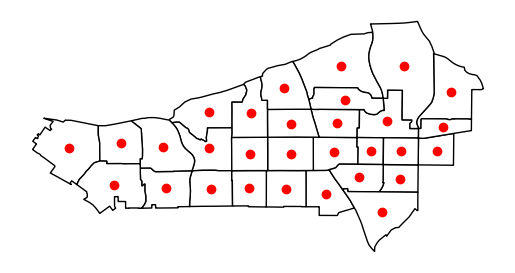

In [128]:
# Create subset of tracts
sub_30 = san_diego_tracts.query("sub_30 == True")
# Plot polygons
ax = sub_30.plot(facecolor="w", edgecolor="k")
# Create and plot centroids
sub_30.head(30).centroid.plot(color="r", ax=ax)
# Remove axis
ax.set_axis_off();

In [129]:
# Build weights with adaptive bandwidth
w_fixed = weights.distance.Kernel.from_dataframe(
    sub_30, fixed=True, k=15
)
# Print first five bandwidth values
w_fixed.bandwidth[:5]

array([[7065.74020822],
       [7065.74020822],
       [7065.74020822],
       [7065.74020822],
       [7065.74020822]])

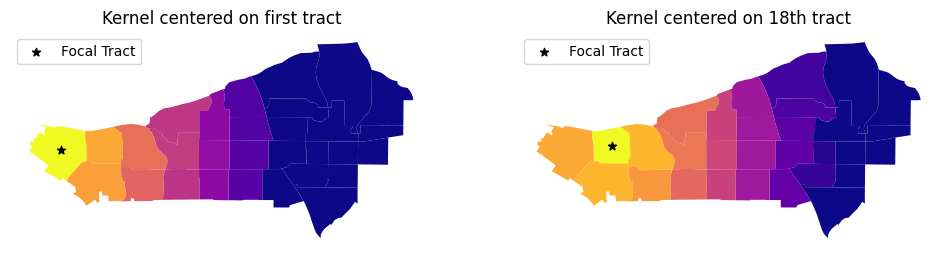

In [130]:
# Create full matrix version of weights
full_matrix, ids = w_fixed.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 2, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)
# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

In [131]:
# Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(
    sub_30, fixed=False, k=15
)
# Print first five bandwidth values
w_adaptive.bandwidth[:5]

array([[7065.74020822],
       [3577.22591841],
       [2989.74807871],
       [2891.46196945],
       [3965.08354232]])

In [151]:
w_adaptive.weights

{19: [1.0,
  0.801898849449034,
  0.7787240875769632,
  0.6403397735248946,
  0.5976639797961802,
  0.4645205996751055,
  0.44629225093646363,
  0.4342639554546358,
  0.30742161414069036,
  0.29191022328108185,
  0.290684984329456,
  0.15363427434081367,
  0.15076782114537057,
  0.14331554881505915,
  0.1426564310077345,
  9.99999900663795e-08],
 25: [1.0,
  0.7228298744975455,
  0.6828129806752778,
  0.5630851313021603,
  0.5554138601181801,
  0.4179134968971173,
  0.40116484297713706,
  0.36875480523241355,
  0.3428766558947103,
  0.3347865757619355,
  0.3040711100710475,
  0.28973288123765994,
  0.17406184671980063,
  0.0858366962691759,
  0.026610129436100416,
  9.99999900663795e-08],
 28: [1.0,
  0.661235037669311,
  0.6363422998570547,
  0.6189926099132147,
  0.5171342105313361,
  0.46279058938663975,
  0.43920089844563637,
  0.34995215940102575,
  0.3099964817319544,
  0.30443443755732924,
  0.29170347564141275,
  0.22070857701788715,
  0.21849998466183074,
  0.1356394091073927,

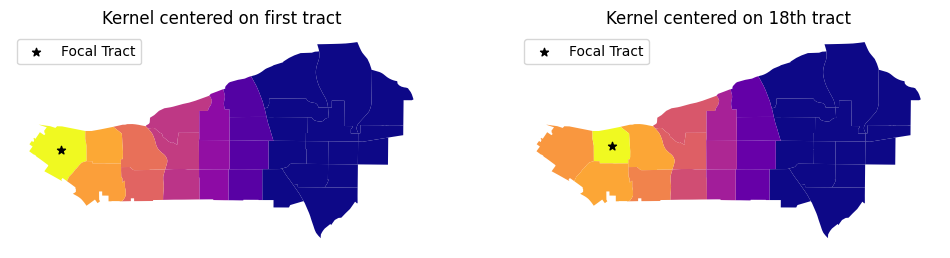

In [132]:
# Create full matrix version of weights
full_matrix, ids = w_adaptive.full()
# Set up figure with two subplots in a row
f, ax = plt.subplots(
    1, 2, figsize=(12, 6), subplot_kw=dict(aspect="equal")
)
# Append weights for first polygon and plot on first subplot
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap="plasma", ax=ax[0]
)
# Append weights for 18th polygon and plot on first subplot
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax[1]
)
# Add centroid of focal tracts
sub_30.iloc[[0], :].centroid.plot(
    ax=ax[0], marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax[1], marker="*", color="k", label="Focal Tract"
)
# Add titles
ax[0].set_title("Kernel centered on first tract")
ax[1].set_title("Kernel centered on 18th tract")
# Remove axis
[ax_.set_axis_off() for ax_ in ax]
# Add legend
[ax_.legend(loc="upper left") for ax_ in ax];

In [133]:
# Show the first five values of bandwidths
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

## Spatial Lag
* A concept that captures the behavior of a variable in the immediate surroundings of each location
* One of the most common and direct applications of spatial weights matrices 

Mathematically: $$\text{spatial lag} = \textbf{W} \times \textbf{Y}$$ 

where $\textbf{W} = (w_{ij})$ is the weight matrix capturing the spatial relationship between observations $i$ and $j$ and $\textbf{Y} = (y_j)$ is the vector of a given variable:

$$Y_{sl} = \textbf{W} Y, \qquad y_{sl-i} = \sum_j w_{ij}y_j$$

Because we have
$$
w_{ij} = 
\begin{cases} 
> 0, \quad \text{if $j$ neighbor of $i$}\\ 
= 0 \quad \text{else}
\end{cases}
$$

$y_{sl-i}$ really captures the product of values and weights for $i$’s neighbors.

* If $\textbf{W}$ is binary, this will amount to the sum of the values of $i$’s neighbors.
* If $\textbf{W}$ is row standardized, then $w_{ij}$ is bounded between 0 and 1. The spatial lag thus becomes a “local average" (the average value of  in the neighborhood of each observation). This will enable analysis of spatial autocorrelation.

#### Smoothening effect of the spatial lag
![brexit_lag](supporting_files/brexit_lag.png)
* imputation method for areas with less data

## Spatial data analysis concepts
Mainly focuses on methods to explore most of the fundamental questions involved in geographical analysis: 
> Whatever the nature of my data, is there a geographical pattern, and are there places where this pattern does not hold?

Points discussed in the following:
1. Spatial Autocorrelation
    1. global
    2. local
2. Other concepts:
    1. Choropleth Mapping
    2. Point Pattern Analysis


## 1. Spatial Autocorrelation
> Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations

#### Positive vs Negative spatial autocorrelation: 
* **Positive:** 
    * similar values are located near each other, while different values are scattered and further away 
    * fairly common case in many social contexts and several human phenomena 
    * examples: distribution of income/poverty
* **Negative:** 
    * similar values are located away from each other $\rightarrow$ statistical similarity is associated with distance 
    * found in phenomena that follow processes of spatial competition or situations where the location of a set of facilities aims at the highest spatial coverage
    * examples: distribution of supermarkets of different brands/hospitals
    
#### Global vs Local spatial autocorrelation: 
* **Global:** 
    * considers overall trend that the location of values follows 
    * $\rightarrow$ possible insights about degree of clustering in the dataset
* **Local:** 
    * focuses on deviations from the global trend at observation level instead of the entire map

### A. Global Moran's $I$

$$I = \frac{n}{\sum_i\sum_j w_{ij}}\cdot \frac{\sum_i\sum_j w_{ij}z_iz_j}{\sum_iz_i^2}$$

#### Moran Plot:
* Scatter plot of variable of interest against its spatial lag (usually standardised)
* Helps visualize the nature and strength of spatial autocorrelation
* Each point: average standardized value in the neighbourhood of each observation
* Red line: best linear fit to the scatter plot $\rightarrow$ slope is given by Moran’s I
* "Leave" voting percentage has positive spatial autocorrelation $\rightarrow$ neighbourhood areas will have similar values

![global_moran_plot](supporting_files/global_moran_plot.png)

Proper way of formulating this result: 
> Local authorities where people voted in high proportion to leave the EU tend to be located nearby other regions that also registered high proportions of Leave vote. 

Global Moran’s $I$ is a good tool to summarize a dataset into a single value that captures the degree of geographical clustering (or dispersion, if negative).
<br>
It can tell us **whether** values in our map cluster together (or disperse) overall, but **not where** specific clusters (or outliers) are.

To find out more about this type of relationships we need to look at **local measures of spatial autocorrelation** which focuses on the **relationships between each observation and its surroundings**, rather than providing a single summary of these relationships across the map


### B. Local Moran's $I$


$$I_i = \frac{z_i}{m_2} \sum_j w_{ij}z_j,$$ 
where
* $m_2=\frac{\sum_i z_i^2}{n}$ is the second moment (variance) of the distribution of values in the data
* $z_i=y_i-\bar y$


#### Moran Plot:
* Same scatter plot as before: variable of interest against its spatial lag
* Divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: 
    1. those with above-average leave voting, which have positive standardized values
    2. and those with below-average leave voting, which feature negative standardized values 
* We obtain four quadrants where each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (Pct_Leave) or its spatial lag (w_Pct_Leave_std). 
* Using this terminology, we name the four quadrants as follows: 
    1. high-high (HH) for the top-right, 
    2. low-high (LH) for the top-left, 
    3. low-low (LL) for the bottom-left, 
    4. high-low (HL) for the bottom right

![local_moran_plot](supporting_files/local_moran_plot.png)

#### Core idea of a local Moran’s $I$: 
> Identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL in the scatterplot above) or dissimilar (HL, LH) than we would expect from pure chance.

## 2. Other concepts

### A. Choropleth Mapping
**Choropleths:** geographic maps that display statistical information encoded in a color palette

1. Decide which attribute $y_i$ you want to consider for each location $i$, e.g., population size, average income,...
2. Define classes $(C_j)_{1 \le j \le n}$ by defining $(c_j)_{1 \le j \le n+1}$ such that $$c_j < y_i \le c_{j+1}, \quad \forall y_i \in C_j$$

Classification methods:
* Equal Intervals
* Quantiles
* Mean-standard deviation
* Maximum Breaks
* Box-Plot
* Head-Tail Breaks
* Jenks Caspall
* Fisher Jenks
* Max-$p$


### B. Point Pattern Analysis
* Concerned with the visualization, description, statistical characterization, and modeling of point patterns, trying to understand the generating process that gives rise and explains the observed data
* Point pattern: a collection of events that could take place in several locations but only happen in a few of them and that are represented by points

$\rightarrow$ Easily put: **Cluster analysis**

Example used in this section: geo-tagged Flickr photos from Tokyo